In [1]:
include("test_definitions.jl")
using KelpTest
using Cubature

In [281]:
"""Like numpy where, but zipped."""
function where(arr::BitArray{2})
    ind = indices(arr)
    [(i,j) for i=ind[1], j=ind[2]][arr]
end

where

In [174]:
a = 5.0
∫(args...) = hquadrature(args...)[1]
ω(θ,ϕ) = [sin(ϕ)*cos(θ), sin(ϕ)*sin(θ), cos(ϕ)]
β(Δ) = a * exp(a*Δ) / (exp(a)-exp(-a)) / (2π)

β (generic function with 1 method)

In [96]:
using Plots

In [21]:
;cd ..

/home/oliver/academic/research/kelp


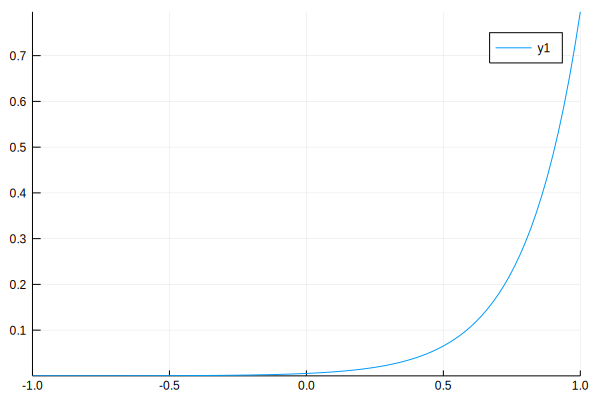

In [252]:
a = 5.0
Δ = linspace(-1,1,101)
plot(Δ, β.(Δ))

In [234]:
nθ = 12
nϕ = 10
nω = nθ * (nϕ-2) + 2
θ, ϕ, θe, ϕe, dθ, dϕ, θₚ, ϕₚ, aₚ, β_vsf, βᵢ_vsf, vsf_angles, vsf_vals = test_make_vsf(nθ, nϕ);

In [184]:
function integrand_2d(X)
    θ, ϕ = X
    β(ω(θ,ϕ) ⋅ ω(0.0, 0.0)) * sin(ϕ)
end

function integrand_4d(X)
    θ, ϕ, θ′, ϕ′ = X
    β(ω(θ,ϕ) ⋅ ω(θ′,ϕ′)) * sin(ϕ) * sin(ϕ′)
end

integrand_4d (generic function with 1 method)

# β is properly normalized

\begin{equation}
    \int_{-1}^1 \beta(\Delta)\, d\Delta = \frac{1}{2\pi}
\end{equation}

In [256]:
hquadrature(β, -1.0, 1.0)[1] * 2π

1.0

\begin{equation}
    \int_{4\pi}\tilde\beta(\vec{\omega}\cdot\vec{\omega}')\, d\vec{\omega} =  1
\end{equation}

In [257]:
hcubature(integrand_2d, (0.0, 0.0), (2π, π))[1]

1.0000000000024238

\begin{equation}
    \int_{4\pi}\int_{4\pi}\tilde\beta(\vec{\omega}\cdot\vec{\omega}')\, d\vec{\omega}\, d\vec{\omega}'  =  4\pi
\end{equation}

In [258]:
ε = 0.0
int = hcubature(integrand_4d, (0.0, ε, 0.0, ε), (2π, π-ε, 2π, π-ε); reltol=1e-4, abstol=1e-4)[1]
int / 4π

0.9999975012744556

# Calculate $\tilde{\beta}_{pp'}$ matrix

In [264]:
function θlims(l, m)
    if 1 < m < nϕ
        if 1 < l
            θmin = θe[l-1]
            θmax = θe[l]
        elseif l == 1
            θmin = θe[end] - 2π
            θmax = θe[l]
        end
    else
        ϕmin = 0.0
        θmax = 2π
    end
    return θmin, θmax
end

function ϕlims(m)
    if 1 < m < nϕ
        ϕmin = ϕe[m-1]
        ϕmax = ϕe[m]
    elseif m == 1
        ϕmin = 0.0
        ϕmax = ϕe[1]
    elseif m == nϕ
        ϕmin = ϕe[end]
        ϕmax = π
    end
    return ϕmin, ϕmax
end
    
function calc_beta_arr(β_arr)
    mvals = convert(Array{Int},1:(nϕ/2))
    futures = []
    for l = 1
        θmin, θmax = θlims(l)
        println("l=$l")
        for m in mvals
            ϕmin, ϕmax = ϕlims(m)
            println("m=$m")
            p = p̂(l,m)
            for l′ = 1:nθ
                θ′min, θ′max = θlims(l′)
                for m′ = 1:nϕ
                    ϕ′min, ϕ′max = ϕlims(m′)
                    p′ = p̂(l′,m′)
                    #=
                    β_arr[p,p′] = hcubature(
                        integrand_4d,
                        (θmin, ϕmin, θ′min, ϕ′min),
                        (θmax, ϕmax, θ′max, ϕ′max),
                        abstol=1e-2, reltol=1e-2
                    )[1]
                    =#
                    β_arr[p,p′] = (
                        ∫(θ -> (
                            ∫(ϕ -> (
                                ∫(θ′ -> (
                                    ∫(ϕ′ -> (begin
                                        #println("ω=($θ,$ϕ). ω′=($θ′,$ϕ′)")
                                        #println("ω⋅ω′ = $(ω(θ,ϕ) ⋅ ω(θ′,ϕ′))")
                                        β(ω(θ,ϕ) ⋅ ω(θ′,ϕ′))
                                    end), ϕmin, ϕmax)
                                ), θ′min, θ′max)
                            ), ϕmin, ϕmax)
                        ), θmin, θmax)
                    )
                    if β_arr[p,p′] < 0
                        println("LESS THAN ZERO")
                        println("l,m,p = $((l,m,p))")
                        println("l′,m′,p′ = $((l′,m′,p′))")
                        println((θe[l-1], ϕe[m-1], θe[l′-1], ϕe[m′-1]))
                        println((θe[l], ϕe[m], θe[l′], ϕe[m′]))
                    end
                end
            end
        end
    end
end

function copy_beta_vals(β_arr)
    let l=1
        # Copy lower hemisphere for l=1
        for m=convert(Array{Int},(nϕ/2+1):nϕ)
            m_orig = nϕ - m + 1
            p = p̂(l, m)
            p_orig = p̂(l, m_orig)
            for l′ = 1:nθ
                for m′ = 1:nϕ
                    m′_orig = nϕ - m′ + 1
                    p′ = p̂(l′, m′)
                    p′_orig = p̂(l′, m′_orig)
                    β_arr[p, p′] = β_arr[p_orig, p′_orig]
                end
            end
        end
    end

    # Copy for all other θ vals
    for l=2:nθ
        for m=2:nϕ-1
            l_orig = 1
            p = p̂(l, m)
            p_orig = p̂(l_orig, m)
            for l′ = 1:nθ
                for m′ = 1:nϕ
                    # Maintain same distance between l and l' as between lₒ and lₒ'.
                    l′_orig = mod1(l_orig + l′ - l, nθ)
                    p′ = p̂(l′, m′)
                    p′_orig = p̂(l′_orig, m′)
                    β_arr[p, p′] = β_arr[p_orig, p′_orig]
                end
            end
        end
    end
end

copy_beta_vals (generic function with 1 method)

In [265]:
β_arr = zeros(nω,nω)
calc_beta_arr(β_arr)

l=1
m=1
m=2
m=3
m=4
m=5


In [229]:
copy_beta_vals(β_arr)

l=1
m=1
m=2
m=3
m=4
m=5


In [295]:
for pair in sort(where(β_arr.!=0))
    println(pair)
end

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(1, 21)
(1, 22)
(1, 23)
(1, 24)
(1, 25)
(1, 26)
(1, 27)
(1, 28)
(1, 29)
(1, 30)
(1, 31)
(1, 32)
(1, 33)
(1, 34)
(1, 35)
(1, 36)
(1, 37)
(1, 38)
(1, 39)
(1, 40)
(1, 41)
(1, 42)
(1, 43)
(1, 44)
(1, 45)
(1, 46)
(1, 47)
(1, 48)
(1, 49)
(1, 50)
(1, 51)
(1, 52)
(1, 53)
(1, 54)
(1, 55)
(1, 56)
(1, 57)
(1, 58)
(1, 59)
(1, 60)
(1, 61)
(1, 62)
(1, 63)
(1, 64)
(1, 65)
(1, 66)
(1, 67)
(1, 68)
(1, 69)
(1, 70)
(1, 71)
(1, 72)
(1, 73)
(1, 74)
(1, 75)
(1, 76)
(1, 77)
(1, 78)
(1, 79)
(1, 80)
(1, 81)
(1, 82)
(1, 83)
(1, 84)
(1, 85)
(1, 86)
(1, 87)
(1, 88)
(1, 89)
(1, 90)
(1, 91)
(1, 92)
(1, 93)
(1, 94)
(1, 95)
(1, 96)
(1, 97)
(1, 98)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(2, 21)
(2, 22)
(2, 23)
(2, 24)
(2, 25)
(2, 26)
(2, 27)
(2, 28)
(2, 29)
(2

## $\tilde{\beta}_{pp'}$ should be symmetric

In [260]:
issymmetric(β_arr)

false

## $\tilde{\beta}_{pp'}$ should integrate to 1 along each row and column

In [263]:
β_arr * aₚ

98-element Array{Float64,1}:
 0.0819952
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 ⋮        
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.199618 
 0.0819952

In [240]:
(β_arr - β_arr')

98×98 Array{Float64,2}:
 0.0        -0.0166952    -0.0166952    …  -0.0166952    0.0      
 0.0166952   0.0           2.42861e-17     -2.42861e-17  0.0166952
 0.0166952  -2.42861e-17   0.0              1.38778e-17  0.0166952
 0.0166952   1.38778e-17  -2.42861e-17      1.04083e-17  0.0166952
 0.0166952   1.04083e-17   1.38778e-17     -6.93889e-18  0.0166952
 0.0166952  -6.93889e-18   1.04083e-17  …  -1.73472e-18  0.0166952
 0.0166952  -1.73472e-18  -6.93889e-18      0.0          0.0166952
 0.0166952   0.0          -1.73472e-18      1.73472e-18  0.0166952
 0.0166952   1.73472e-18   0.0              6.93889e-18  0.0166952
 0.0166952   6.93889e-18   1.73472e-18     -1.04083e-17  0.0166952
 0.0166952  -1.04083e-17   6.93889e-18  …  -1.38778e-17  0.0166952
 0.0166952  -1.38778e-17  -1.04083e-17      2.42861e-17  0.0166952
 0.0166952   2.42861e-17  -1.38778e-17      0.0          0.0166952
 ⋮                                      ⋱                         
 0.0166952  -2.42861e-17   0.0        

In [194]:
diag(β_arr)

98-element Array{Float64,1}:
 4.82554e-5
 0.0       
 0.00289896
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 ⋮         
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       
 0.0       

In [62]:
(l̂(2),m̂(2)), (l̂(3),m̂(3))

((1, 2), (2, 2))

In [277]:
indices(β_arr.<0)

(Base.OneTo(98), Base.OneTo(98))

In [278]:
np_where(β_arr.!=0)

490-element Array{Tuple{Int64,Int64},1}:
 (1, 1)  
 (2, 1)  
 (14, 1) 
 (26, 1) 
 (38, 1) 
 (1, 2)  
 (2, 2)  
 (14, 2) 
 (26, 2) 
 (38, 2) 
 (1, 3)  
 (2, 3)  
 (14, 3) 
 ⋮       
 (26, 96)
 (38, 96)
 (1, 97) 
 (2, 97) 
 (14, 97)
 (26, 97)
 (38, 97)
 (1, 98) 
 (2, 98) 
 (14, 98)
 (26, 98)
 (38, 98)

In [58]:
β_arr[β_arr.!=0]

736-element Array{Float64,1}:
  8.70517    
  5.84713    
  3.07479    
  1.32638    
 -0.768301   
  0.0967629  
 -0.501989   
  0.0811411  
 -0.258455   
  0.0494286  
 -0.110163   
  0.0230283  
 -0.778836   
  ⋮          
 -0.0169296  
  0.0013034  
 -0.0445106  
  0.00327992 
 -0.00406958 
  0.000440904
 -0.00707833 
  0.000850676
 -0.016138   
  0.00203447 
 -0.042118   
  0.00539356 

In [14]:
I = SharedArray{Int}(4,10)
J = SharedArray{Int}(4,10)

4×10 SharedArray{Int64,2}:
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0

In [15]:
q = @parallel for i in 1:4
    for j=1:10
        I[i,j] = i
        J[i,j] = j
    end
end 

1-element Array{Future,1}:
 Future(1, 1, 5, #NULL)

In [16]:
q

1-element Array{Future,1}:
 Future(1, 1, 5, #NULL)

In [17]:
I

4×10 SharedArray{Int64,2}:
 1  1  1  1  1  1  1  1  1  1
 2  2  2  2  2  2  2  2  2  2
 3  3  3  3  3  3  3  3  3  3
 4  4  4  4  4  4  4  4  4  4

In [18]:
J

4×10 SharedArray{Int64,2}:
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10
 1  2  3  4  5  6  7  8  9  10

In [19]:
x

LoadError: [91mUndefVarError: x not defined[39m

In [20]:
x

LoadError: [91mUndefVarError: x not defined[39m